### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from analysis.plot_utils import *
import pandas as pd
from datasets import load_dataset
from collections import Counter

In [2]:
all_df = prepare_df()

# Add the debate leak check
checks_df = load_all_records_into_df('debate_checks').drop_duplicates(['run_id_debate_checks', 'record_id_debate_checks'], keep='last')
all_df = all_df.merge(checks_df, left_on=['debate_run_id_verdicts', 'record_id_verdicts'], right_on=['run_id_debate_checks', 'record_id_debate_checks'], how='left')

### 2 vs 4 choice

In [3]:
verdict_ids_2_choice_gpqa =  ['o6nh196', 'se5tc1t', 'okcg9s1', 'px68tl7', 'gt5hbbc', 'omurjjz', '2ayhhpd', '7ir6j2d', 'mr8lipz', 'kn8lecm', 'k26y5y6', 'uopuf76', 'hmsolpd', 'wvubqq5', '0q341gz', 'm6zo8vx', 'jgrph0e']
verdict_ids_4_choice_gpqa =  ['2bmbqk1', 'po3v9oq', 'qx50tbo', 'jm9kod3', '4rg7b4b', 'faqmo5o', 'dph0qre', '9jiz6cv', 'p8zeu0p', 'ouuwuug', 'yt32eoi', 'vwmy4y3', 'qiqr2wo', '2pvnm1z', 'ujzubt9', '4ukh5h7', '3oxc0v3']

verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa + verdict_ids_4_choice_gpqa)]

# optionally, only keep records that don't have a leak
verdicts_df = verdicts_df[verdicts_df['has_leak_debate_checks'] == False]

# optionally, only keep recordsthat appear in both 2 and 4 choice
verdicts_df = verdicts_df[verdicts_df.groupby(['config_judge_model_verdicts', 'question_idx_debates']).transform('size')==2].reset_index(drop=True)
# optionally, only keep records (questions) that appear in every run (or adjust to >= tot_runs - x to make more lenient)
# tot_runs = len(verdict_ids_2_choice_gpqa + verdict_ids_4_choice_gpqa) 
# verdicts_df = verdicts_df[verdicts_df.groupby(['question_idx_debates']).transform('size') >= tot_runs-5].reset_index(drop=True)  # 

df_2_choice_gpqa = verdicts_df[verdicts_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa)]
df_4_choice_gpqa = verdicts_df[verdicts_df['verdict_run_id_verdicts'].isin(verdict_ids_4_choice_gpqa)]

acc_2_choice_gpqa = aggregate_by_fields(df_2_choice_gpqa, ['config_judge_model_verdicts'])
acc_4_choice_gpqa = aggregate_by_fields(df_4_choice_gpqa, ['config_judge_model_verdicts'])

print(df_2_choice_gpqa.shape, df_4_choice_gpqa.shape)

(1525, 87) (1525, 87)


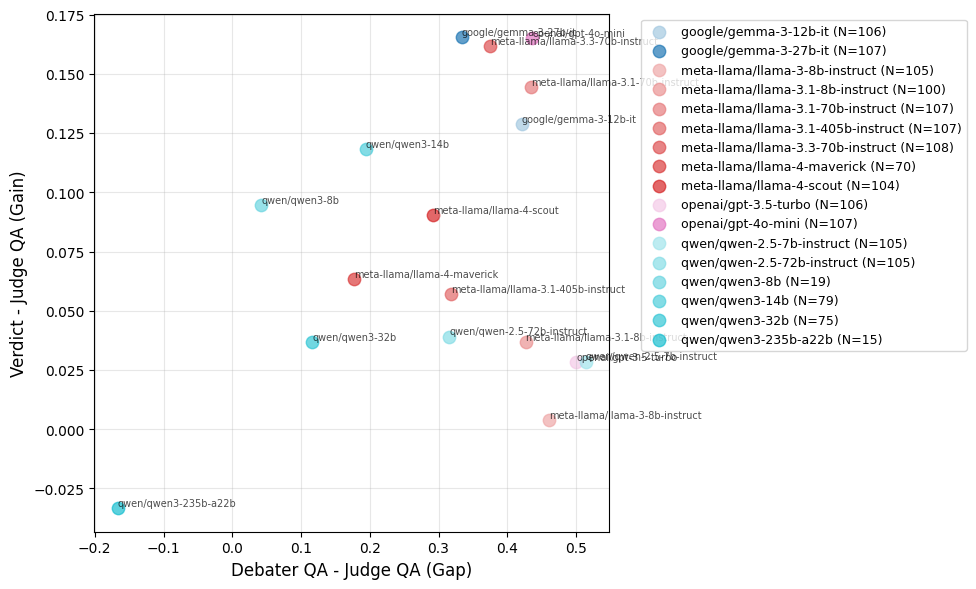

In [4]:
results_df = acc_4_choice_gpqa
# results_df = results_df[results_df['n_total'] > 45]
plot_gain_scatter(results_df, n_choices=4, over='gap') # or over=judge_qa

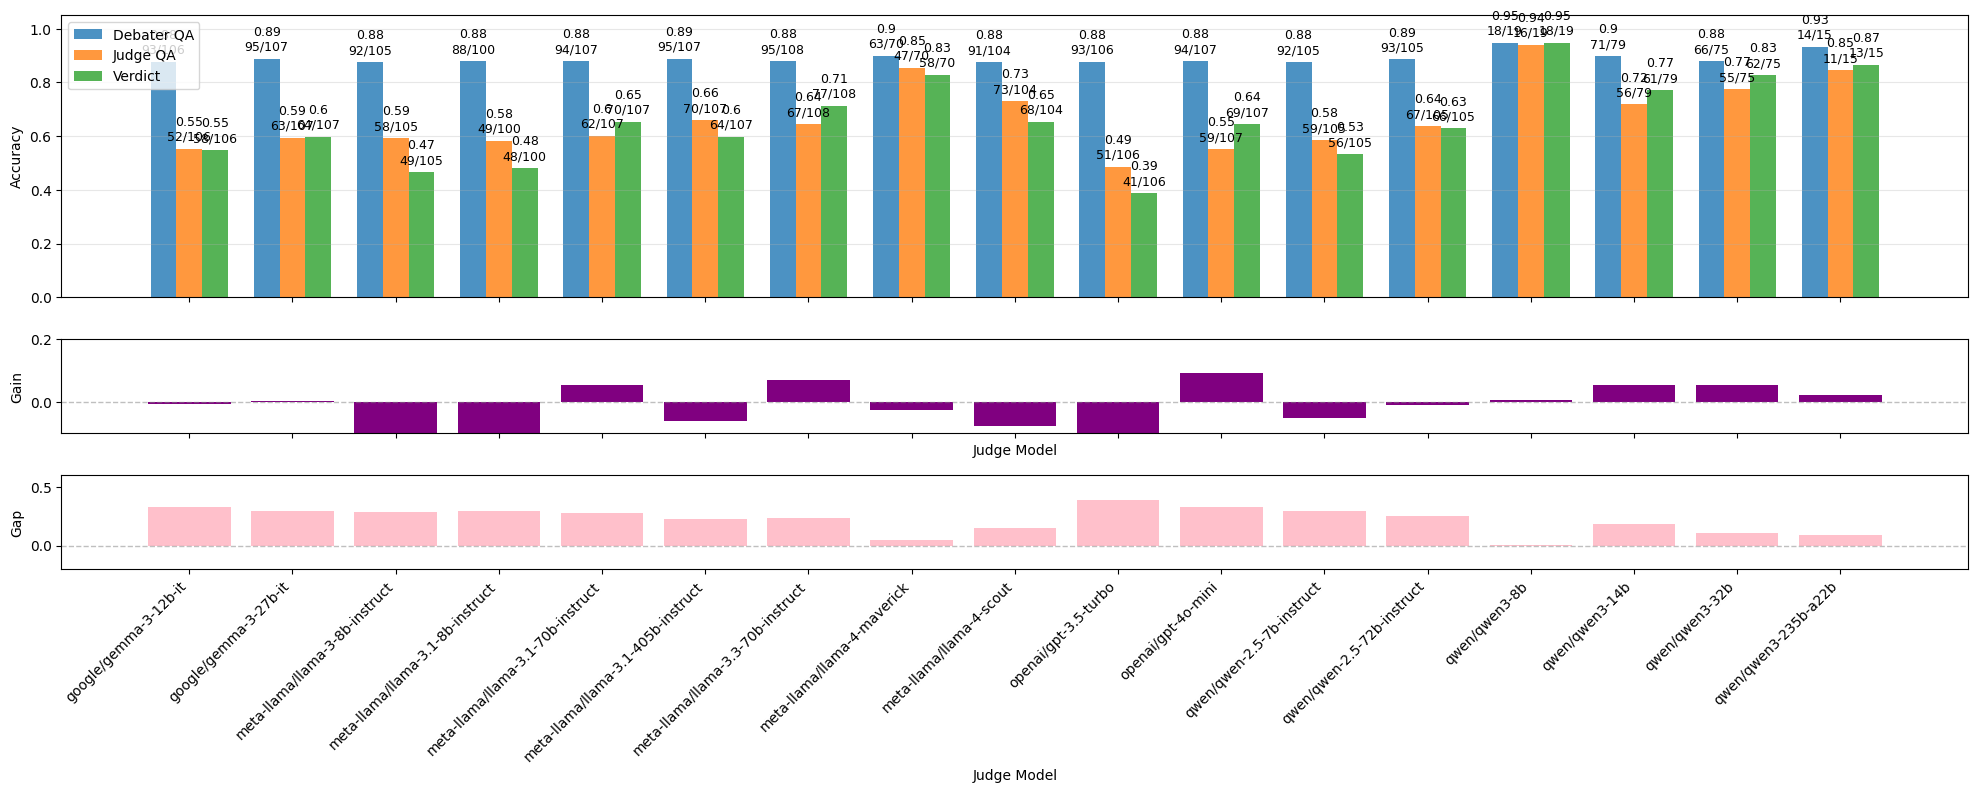

In [5]:
plt, ax_gain, ax_gap = plot_results_by_name(acc_2_choice_gpqa)
ax_gain.set_ylim([-.1, .2])
ax_gap.set_ylim([-.2, .6])
plt.show()

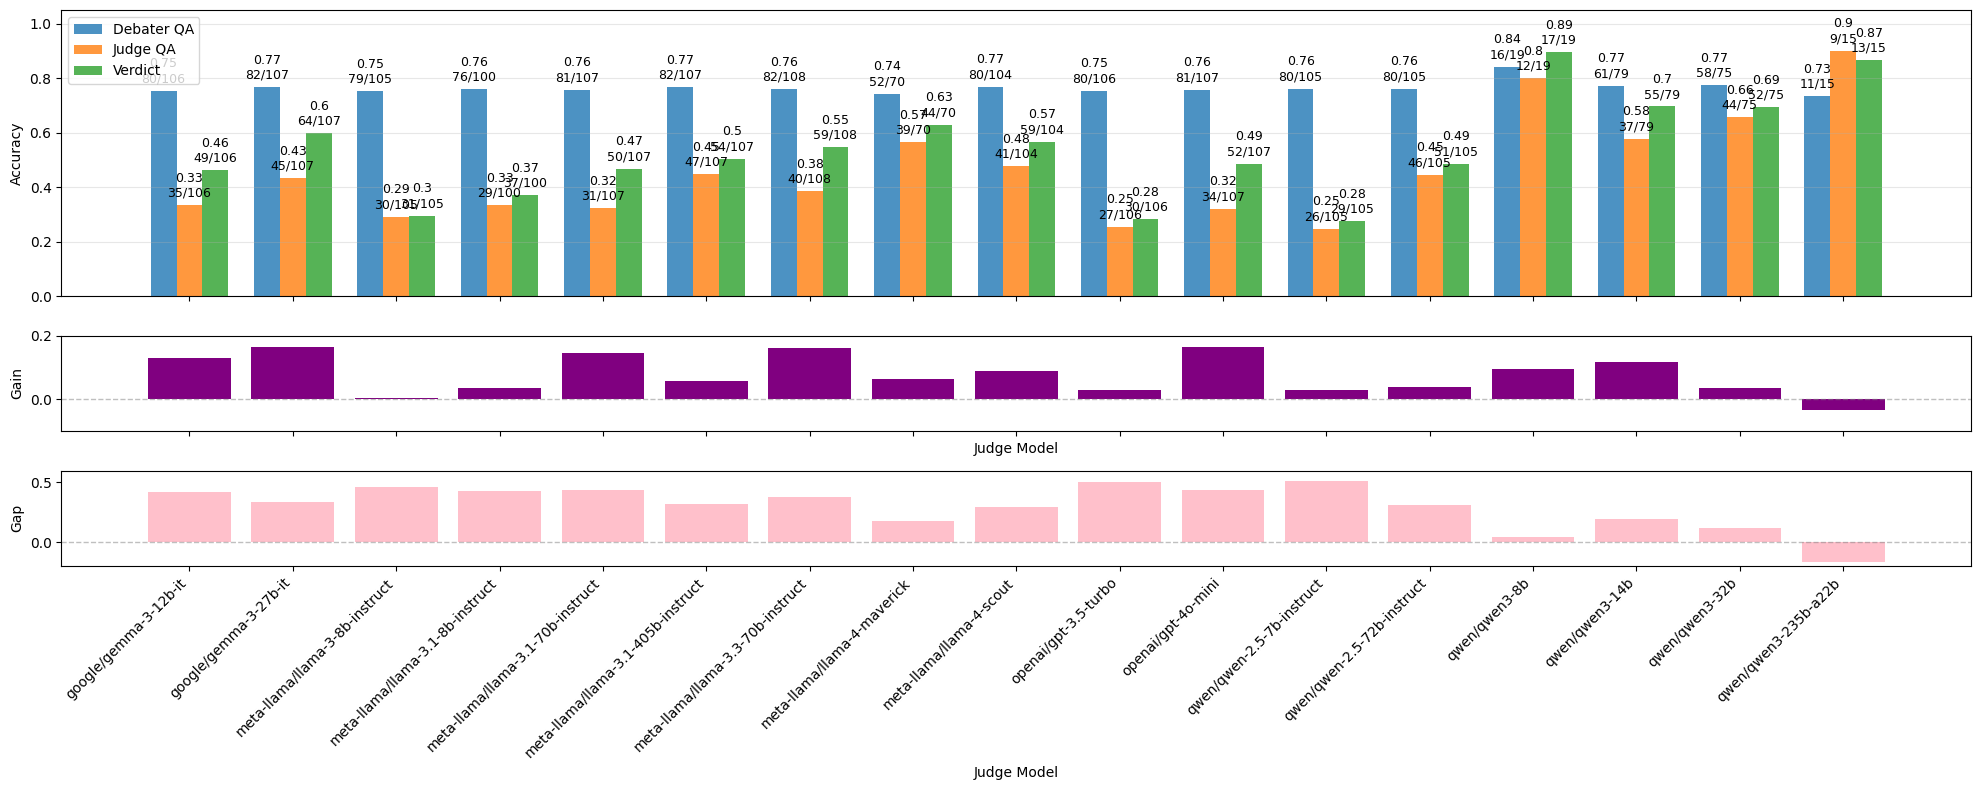

In [6]:
plt, ax_gain, ax_gap = plot_results_by_name(acc_4_choice_gpqa)
ax_gain.set_ylim([-.1, .2])
ax_gap.set_ylim([-.2, .6])
plt.show()

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/plot_utils.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['sort_order'] = merged['name'].map({name: i for i, name in enumerate(sorted_names)})


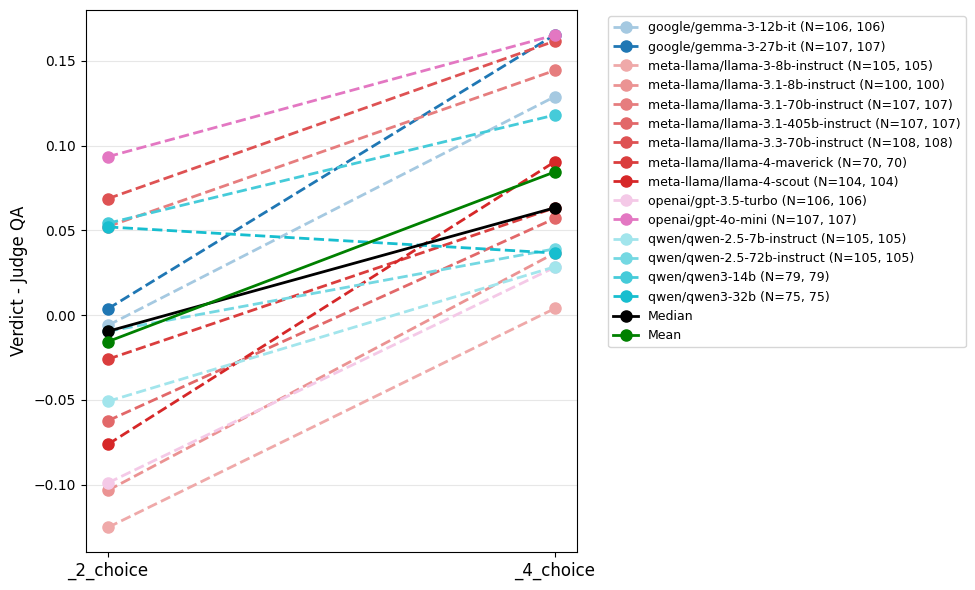

In [7]:
suffixes = ['_2_choice', '_4_choice']
merged_acc = acc_2_choice_gpqa.merge(acc_4_choice_gpqa, on='name', suffixes=suffixes)


# temp = merged_acc
temp = merged_acc[(merged_acc[f'n_total{suffixes[0]}'] > 45) & (merged_acc[f'n_total{suffixes[1]}'] > 45)]
plot_spaghetti(temp, suffixes)

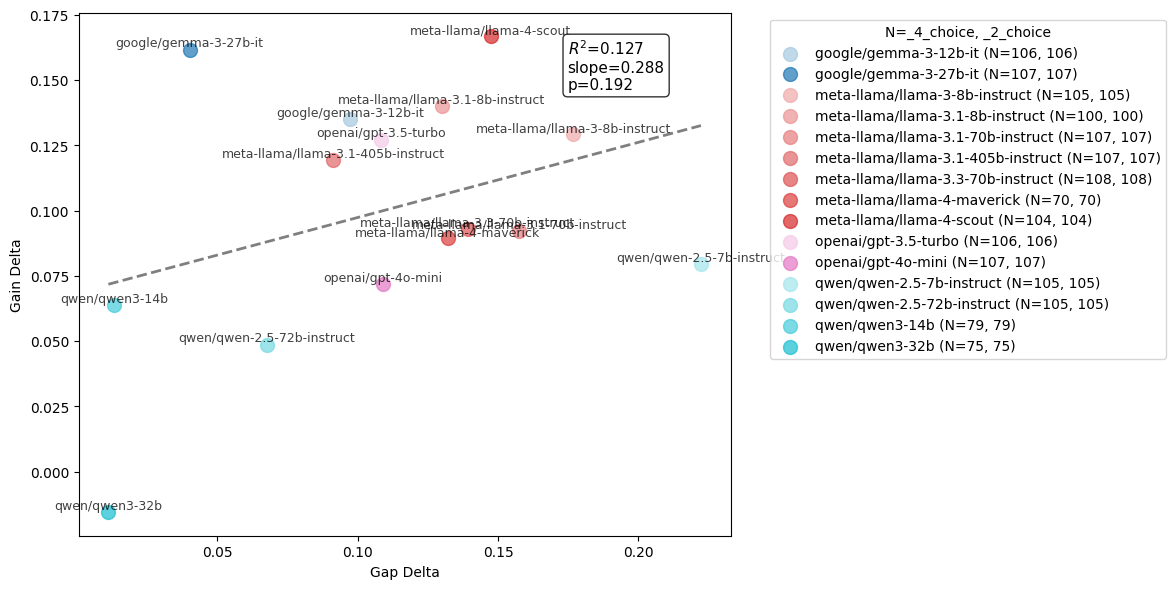

In [8]:
suffixes = ['_4_choice', '_2_choice']

# temp = merged_acc
temp = merged_acc[(merged_acc[f'n_total{suffixes[0]}'] > 45) & (merged_acc[f'n_total{suffixes[1]}'] > 45)]
plot_delta_over_delta(temp, suffixes, xfield='gap_delta', yfield='gain_delta')

### Chemistry vs Physics

In [9]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)

In [10]:
# temp_df = verdicts_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
temp_df = df_4_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
# temp_df = df_2_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))


chemistry_df = temp_df[temp_df['high_level_domain'] == 'Chemistry']
physics_df = temp_df[temp_df['high_level_domain'] == 'Physics']

chemistry_gpqa_acc = aggregate_by_fields(chemistry_df, ['config_judge_model_verdicts'])
physics_gpqa_acc = aggregate_by_fields(physics_df, ['config_judge_model_verdicts'])

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


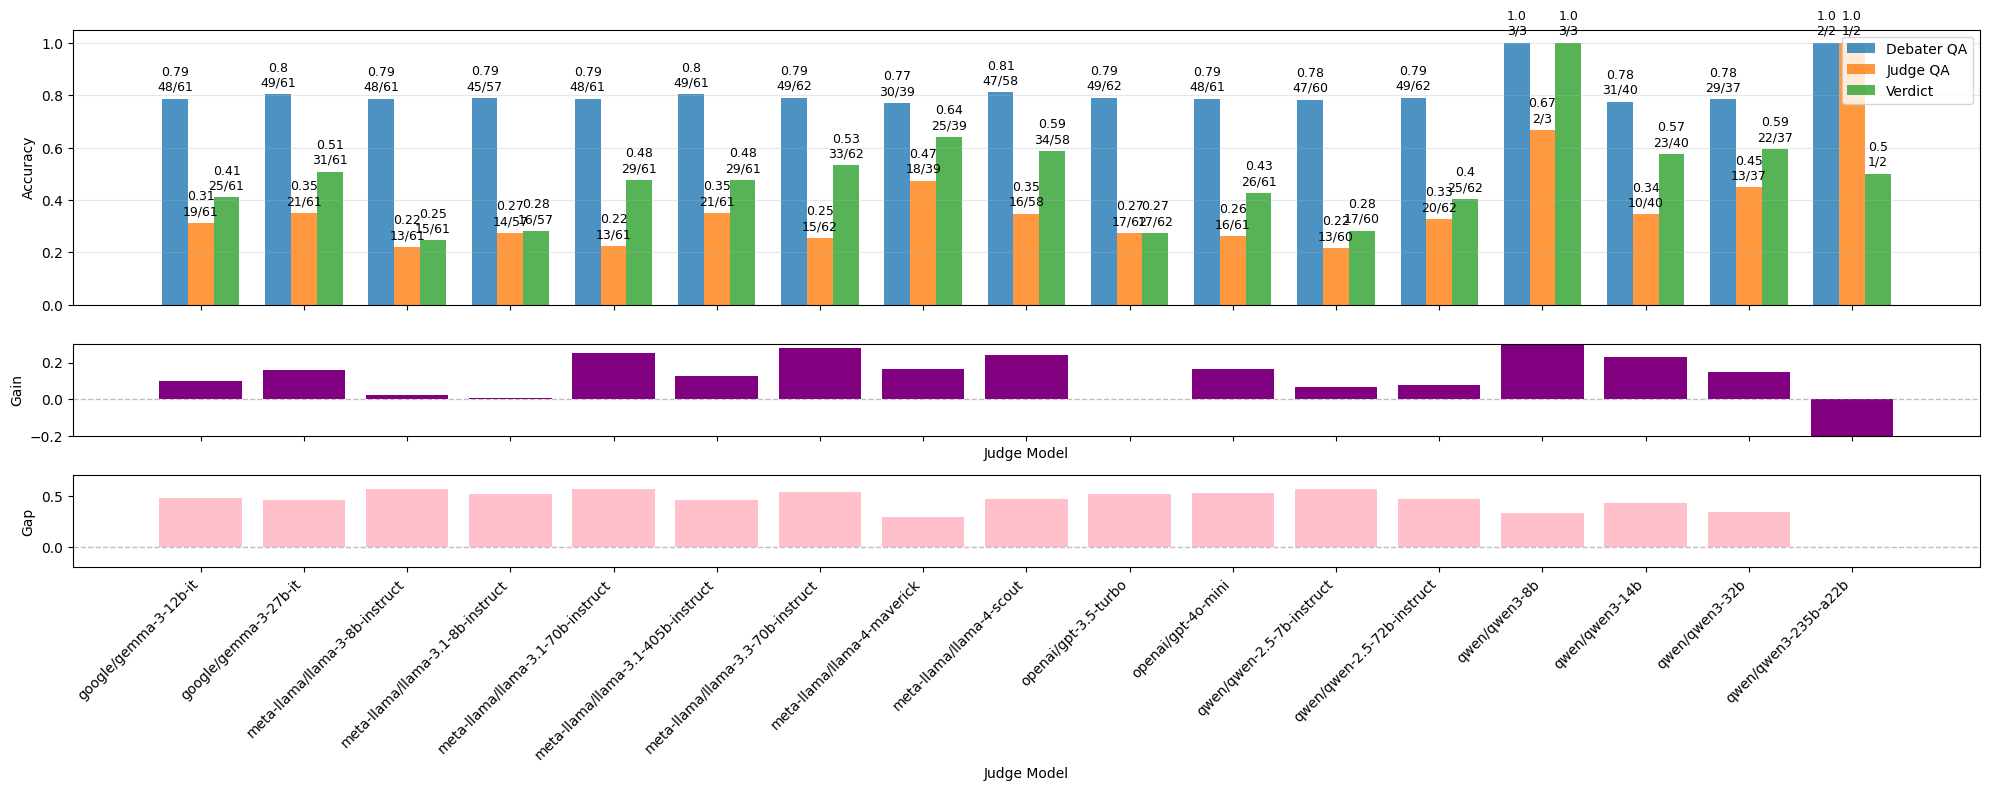

In [11]:
plt, ax_gain, ax_gap = plot_results_by_name(chemistry_gpqa_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

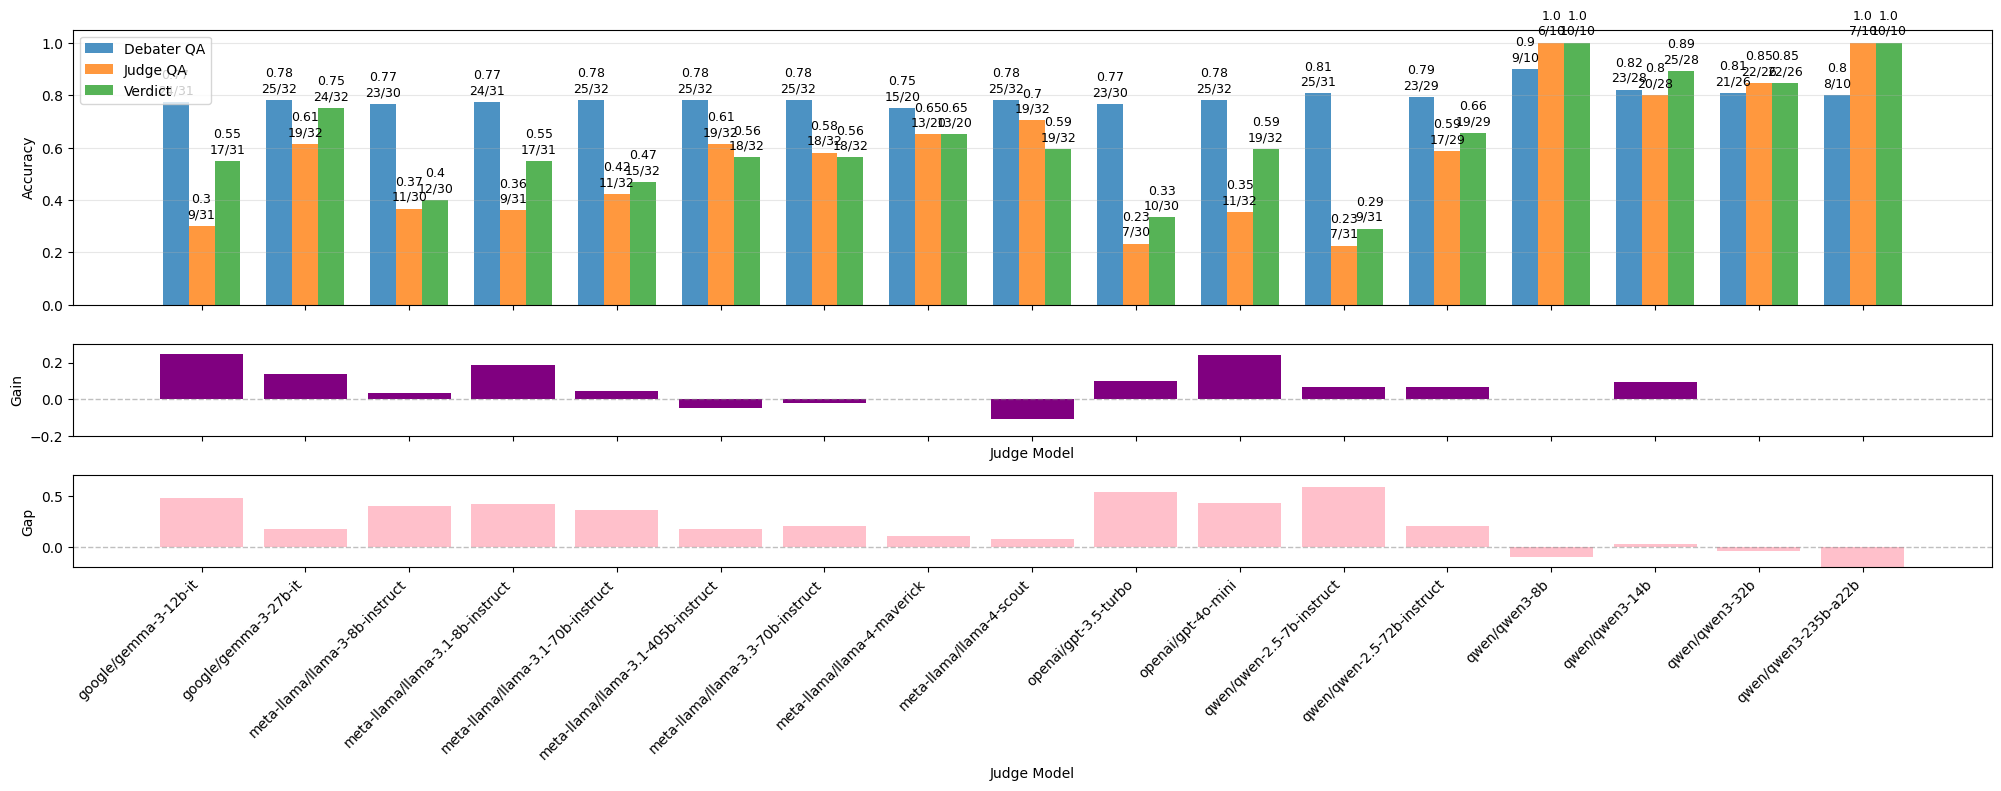

In [12]:
plt, ax_gain, ax_gap = plot_results_by_name(physics_gpqa_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

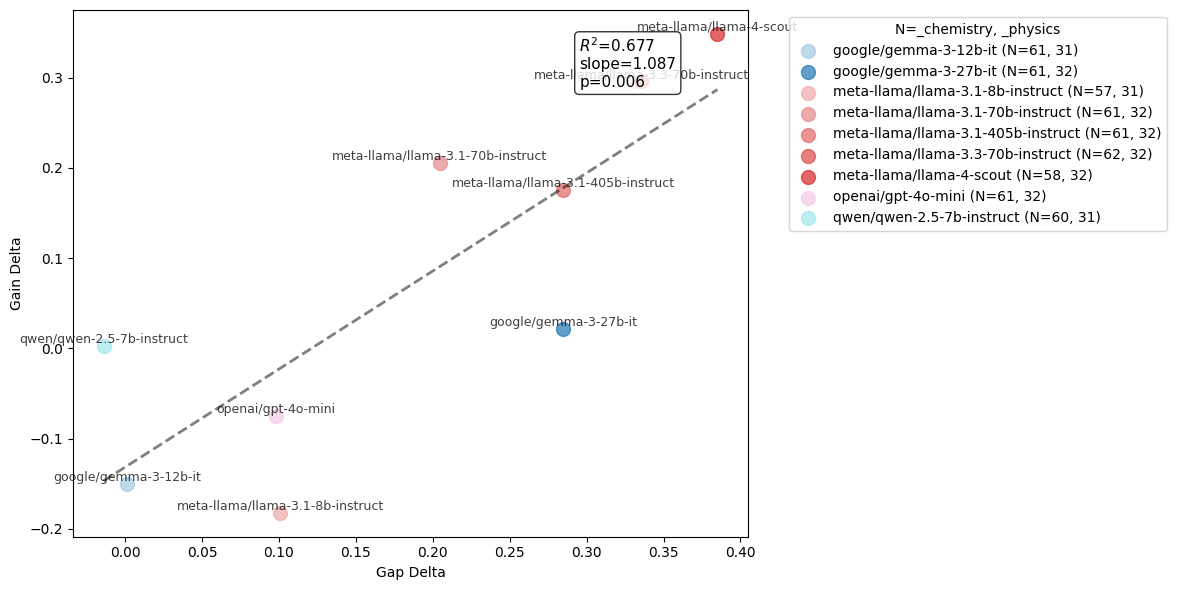

In [13]:
suffixes = ['_chemistry', '_physics']

merged_domains = chemistry_gpqa_acc.merge(physics_gpqa_acc, on='name', suffixes=suffixes)

temp = merged_domains
temp = merged_domains[(merged_domains['n_total_chemistry'] > 30) & (merged_domains['n_total_physics'] > 30)]
plot_delta_over_delta(temp, suffixes, xfield='gap_delta', yfield='gain_delta')

### Random Partition

In [14]:
temp_df = df_4_choice_gpqa

question_idxs = temp_df['question_idx_debates'].unique()

# choose 50 indexes at random (without replacement) 
set_1 = np.random.choice(question_idxs, size=50, replace=False)
set_2 = np.setdiff1d(question_idxs, set_1)

set_1_df = temp_df[temp_df['question_idx_debates'].isin(set_1)].reset_index(drop=True)
set_1_df['set'] = 'set_1'
set_2_df = temp_df[temp_df['question_idx_debates'].isin(set_2)].reset_index(drop=True)
set_2_df['set'] = 'set_2'

set_1_acc = aggregate_by_fields(set_1_df, ['config_judge_model_verdicts'])
set_2_acc = aggregate_by_fields(set_2_df, ['config_judge_model_verdicts'])


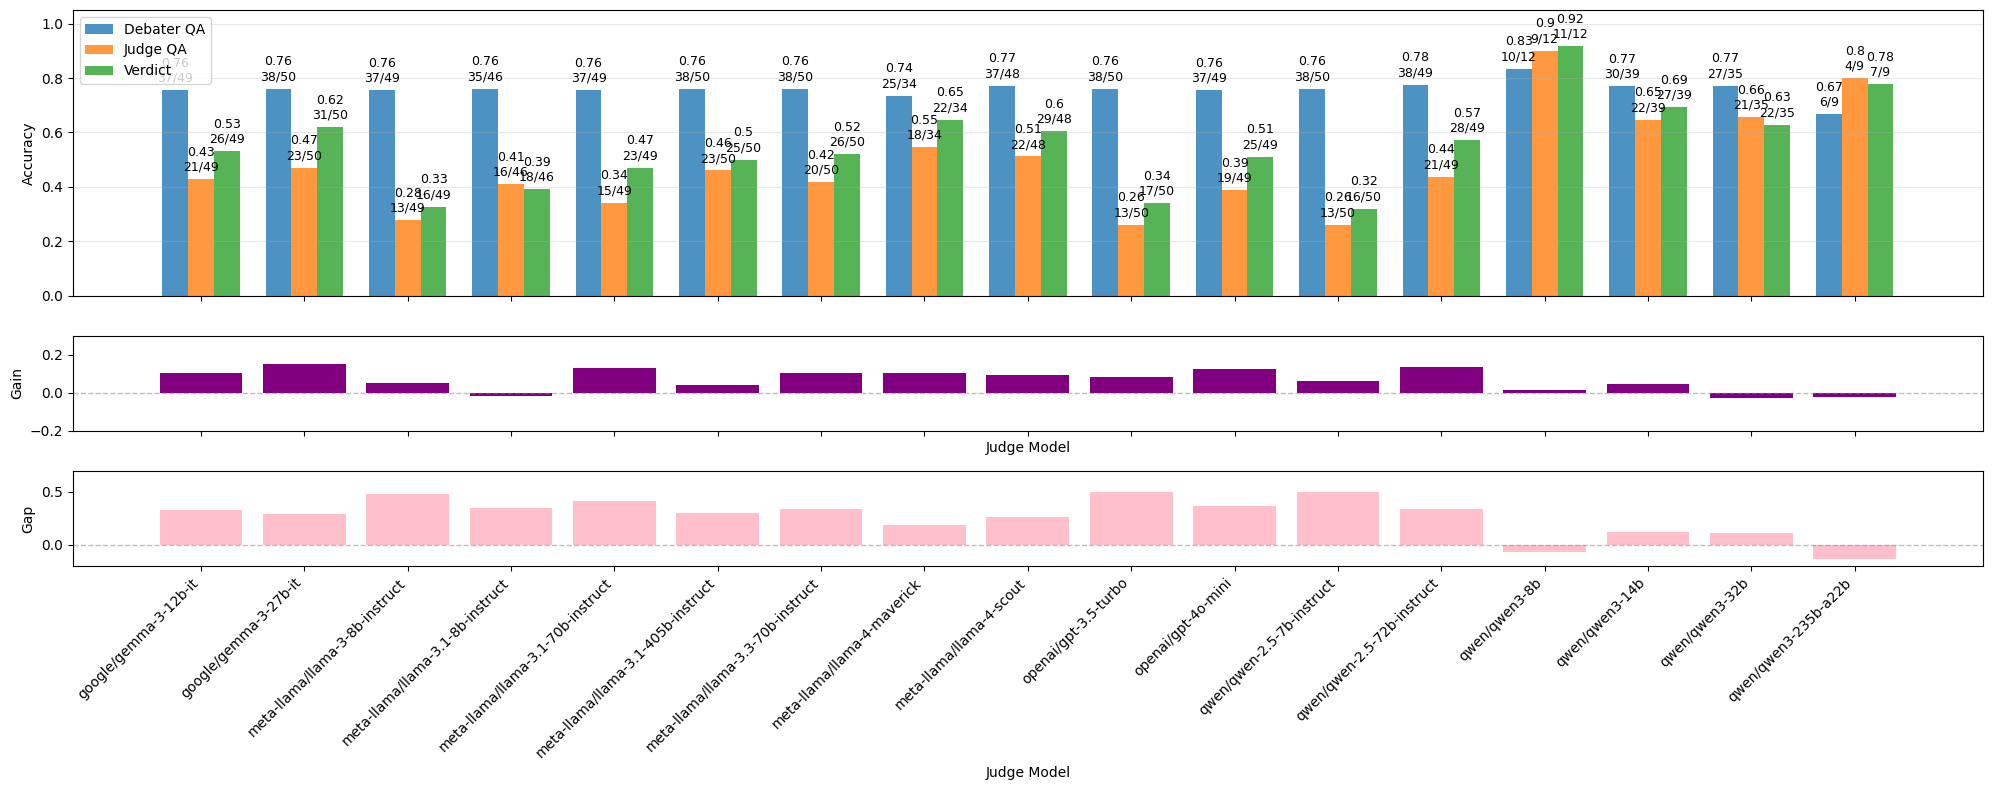

In [15]:
plt, ax_gain, ax_gap = plot_results_by_name(set_1_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

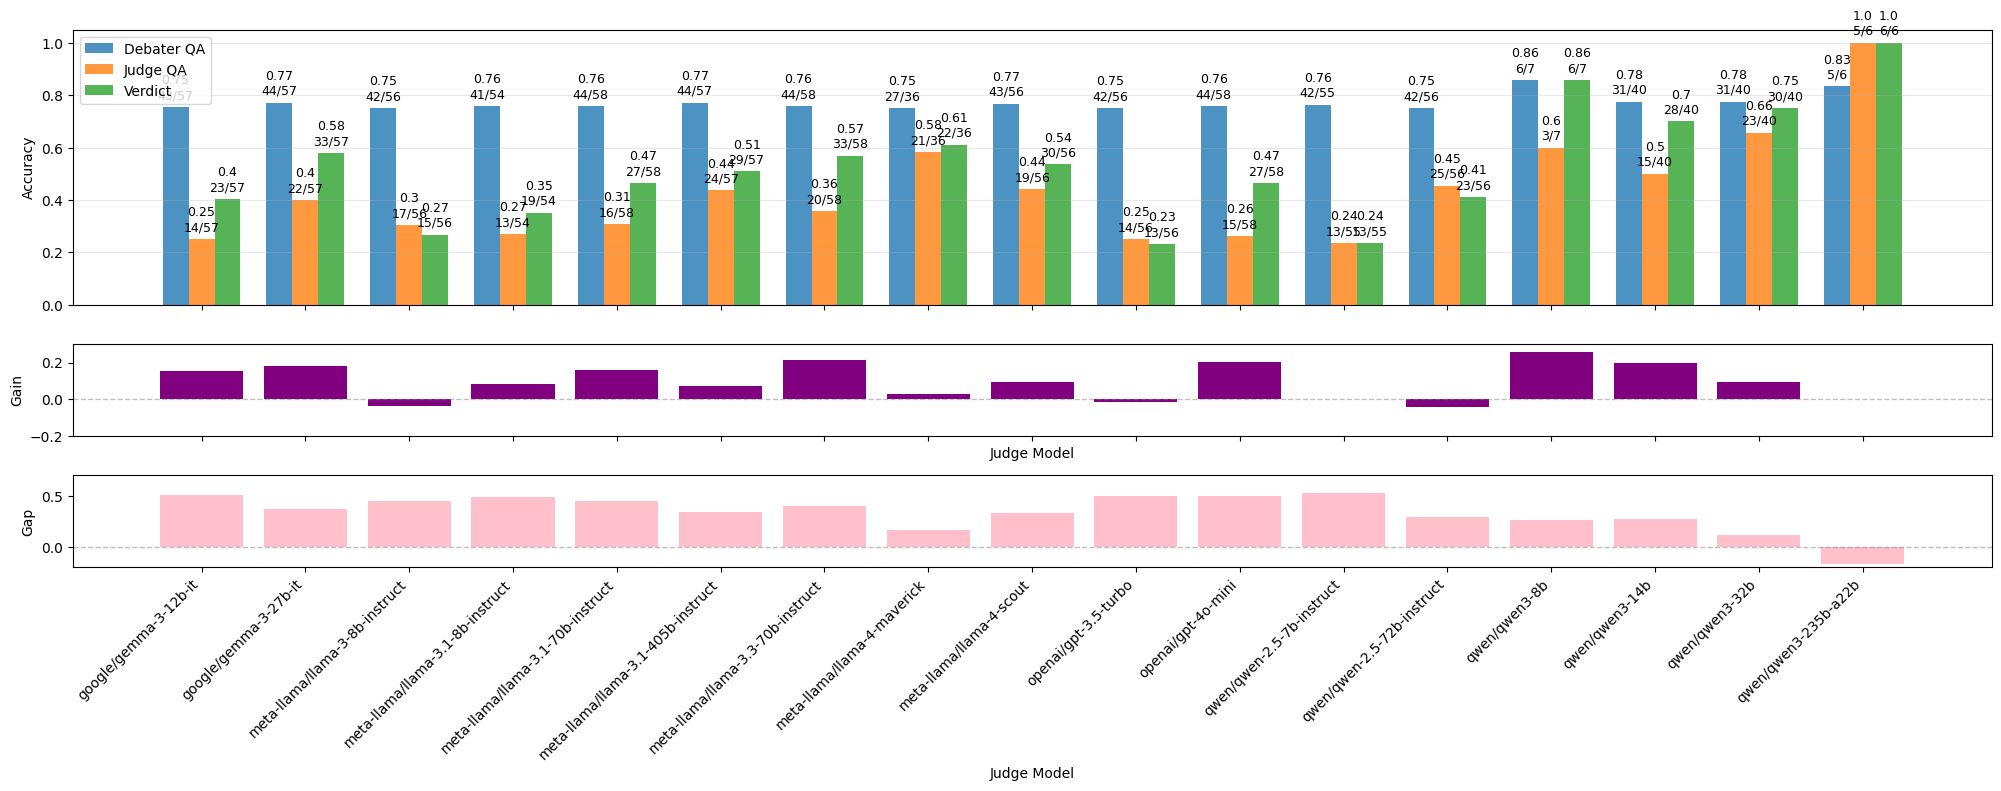

In [16]:
plt, ax_gain, ax_gap = plot_results_by_name(set_2_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

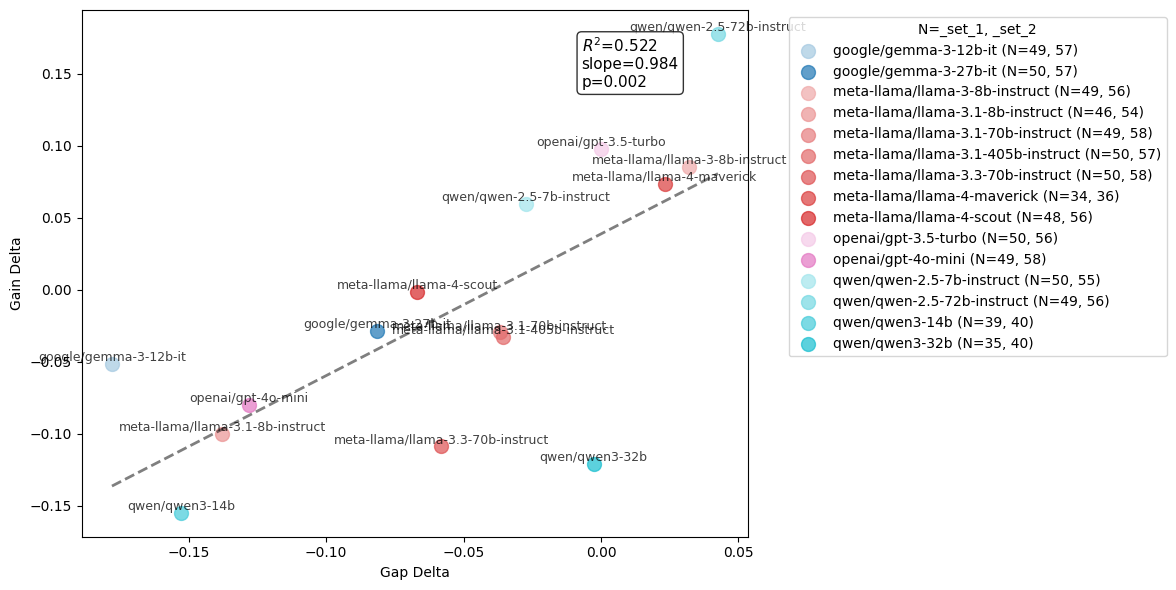

In [17]:
suffixes = ['_set_1', '_set_2']
merged_sets = set_1_acc.merge(set_2_acc, on='name', suffixes=suffixes)

temp = merged_sets
temp = merged_sets[(merged_sets['n_total_set_1'] > 30) & (merged_sets['n_total_set_2'] > 30)]
plot_delta_over_delta(temp, suffixes, xfield='gap_delta', yfield='gain_delta')

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/plot_utils.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['sort_order'] = merged['name'].map({name: i for i, name in enumerate(sorted_names)})


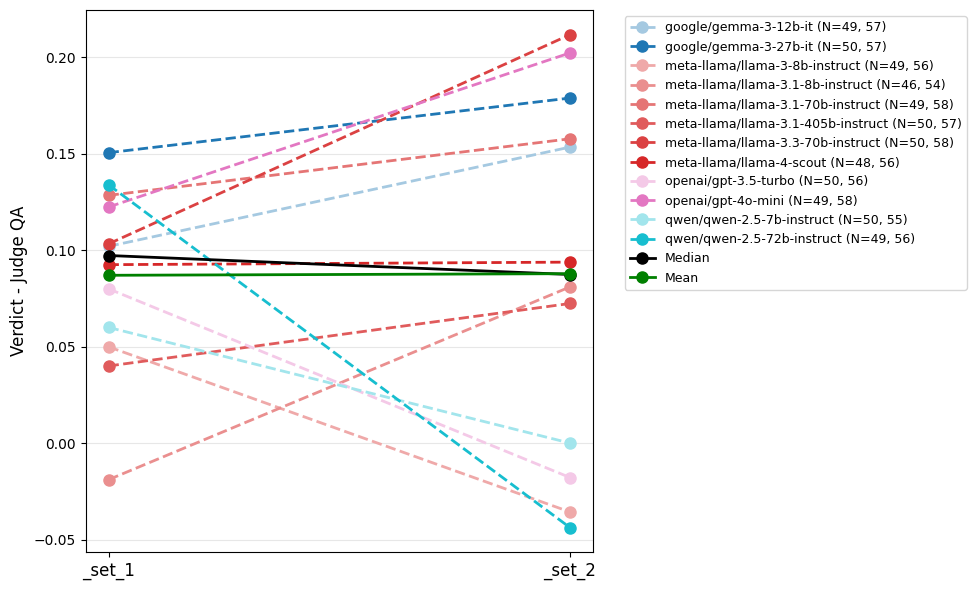

In [18]:
suffixes = ['_set_1', '_set_2']
merged_choice = set_1_acc.merge(set_2_acc, on='name', suffixes=suffixes)

# temp = merged_choice
temp = merged_choice[(merged_choice[f'n_total{suffixes[0]}'] > 45) & (merged_choice[f'n_total{suffixes[1]}'] > 45)]
plot_spaghetti(temp, suffixes)

### Partition instead by judge performance (not verdict)

In [19]:
# hypothesis: the verdict delta will be huge compared to those where the judge is right

temp_df = df_2_choice_gpqa

right_qa_df = temp_df[temp_df['is_correct_qa_judge'] == True]
wrong_qa_df = temp_df[temp_df['is_correct_qa_judge'] == False]
print(right_qa_df.shape, wrong_qa_df.shape)

right_qa_acc = aggregate_by_fields(right_qa_df, ['config_judge_model_verdicts'])
wrong_qa_acc = aggregate_by_fields(wrong_qa_df, ['config_judge_model_verdicts'])



(915, 87) (532, 87)


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


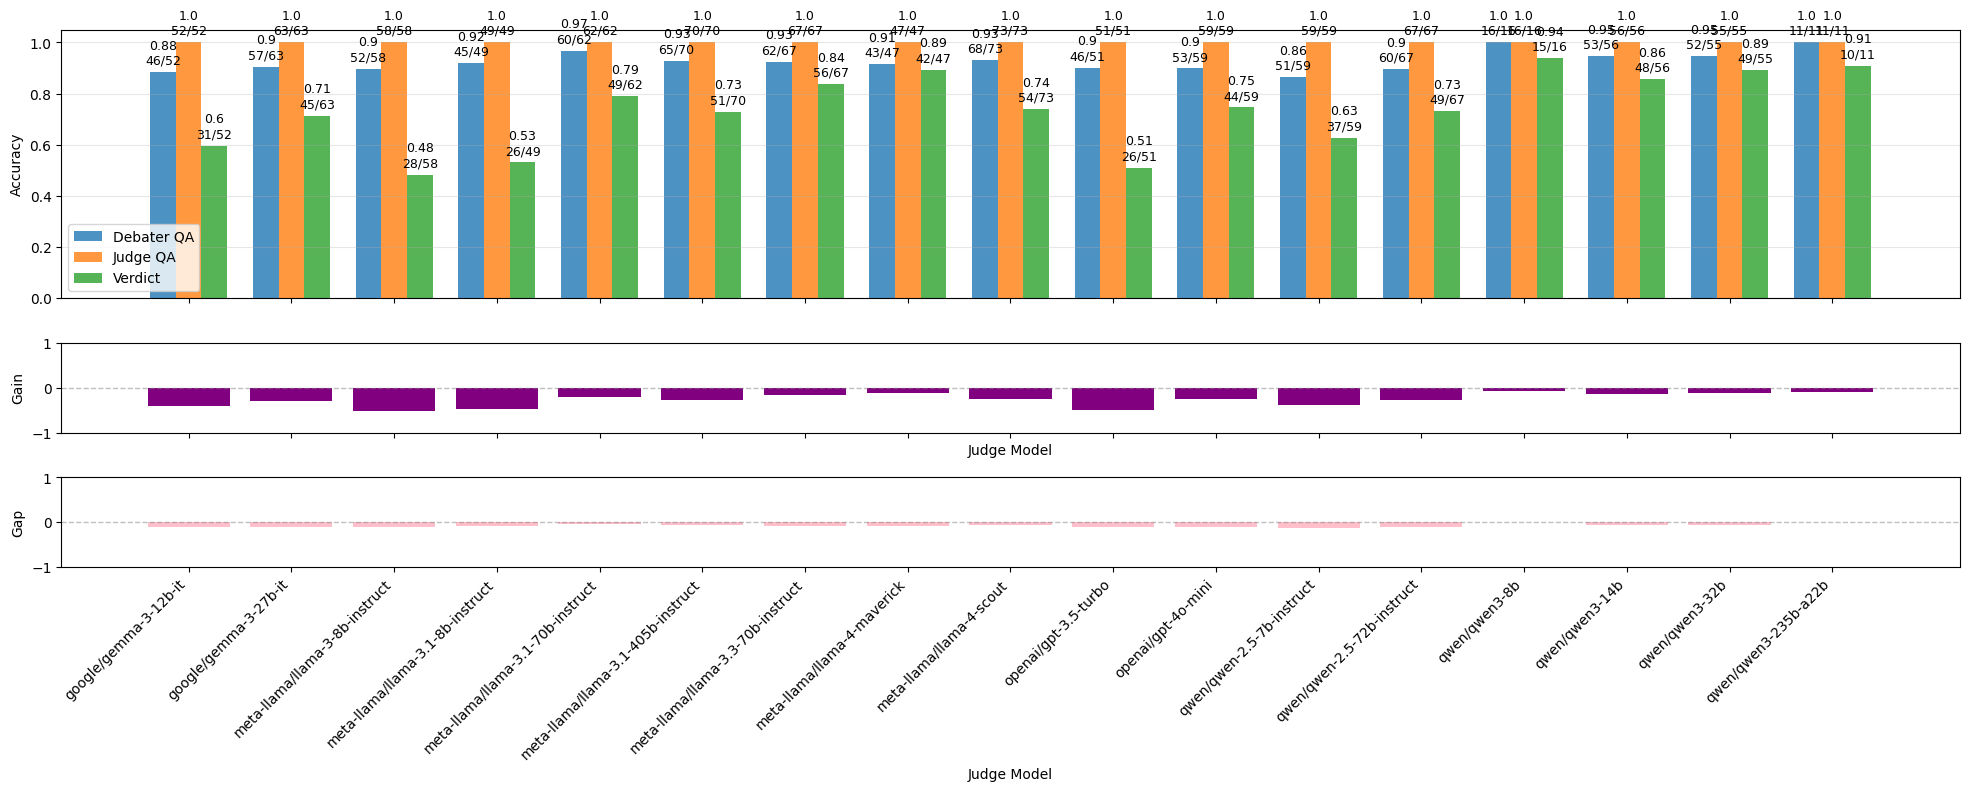

In [20]:
plt, ax_gain, ax_gap = plot_results_by_name(right_qa_acc)
ax_gain.set_ylim([-1, 1])
ax_gap.set_ylim([-1, 1])
plt.show()

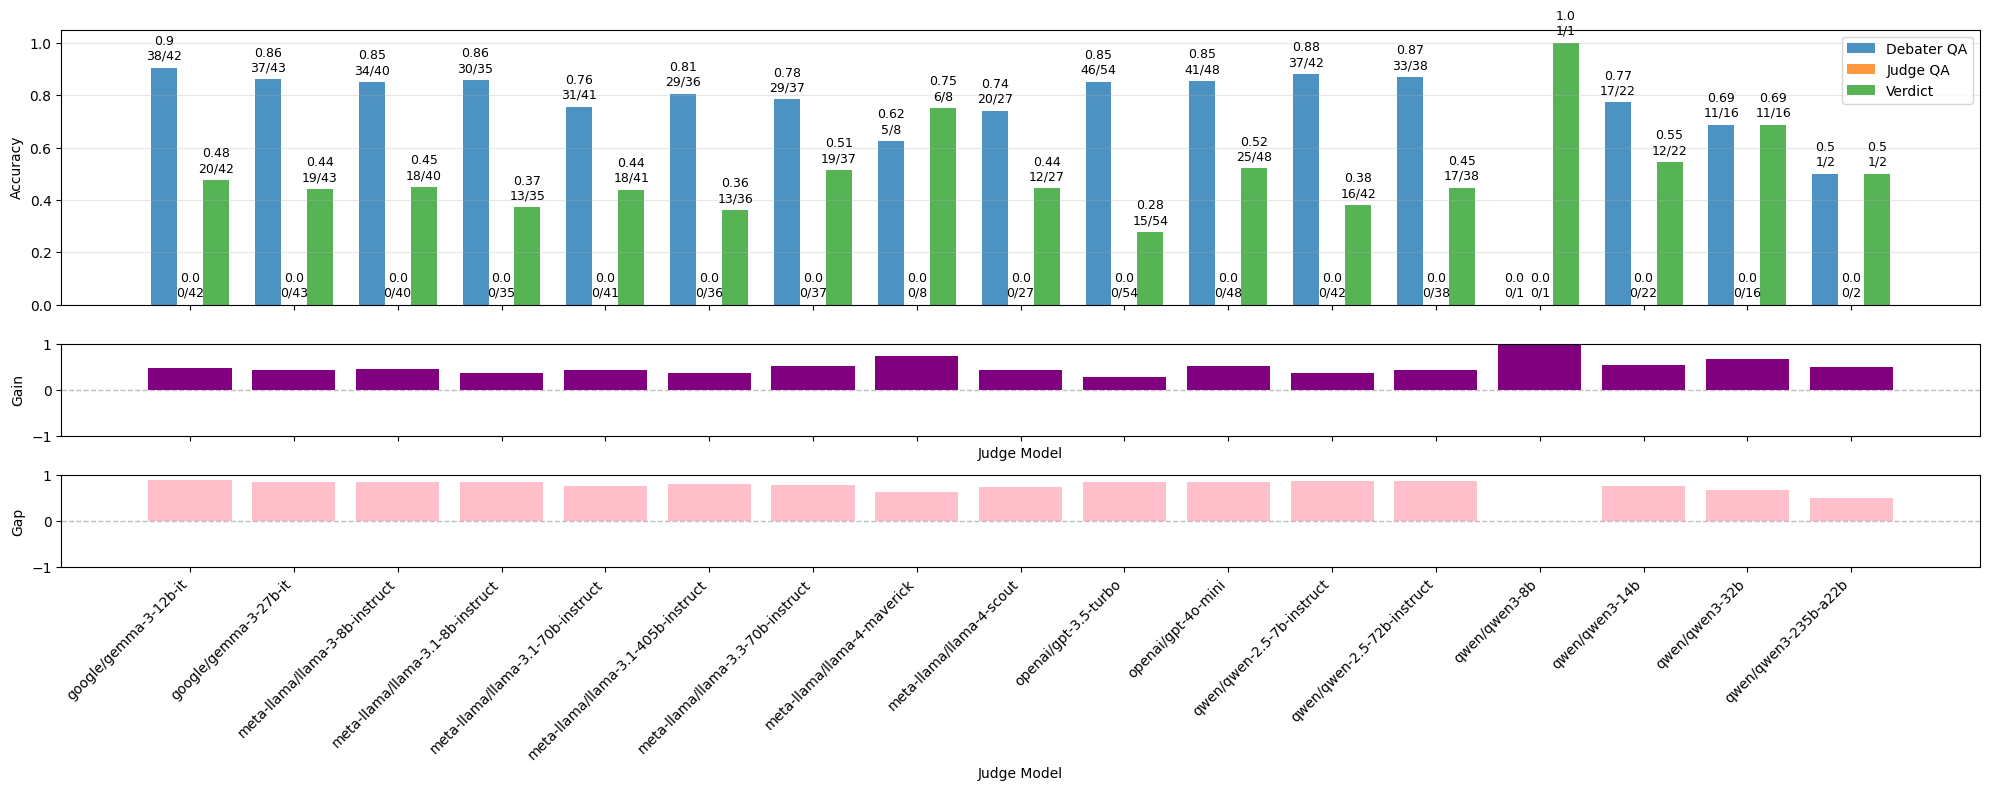

In [21]:
plt, ax_gain, ax_gap = plot_results_by_name(wrong_qa_acc)
ax_gain.set_ylim([-1, 1])
ax_gap.set_ylim([-1, 1])
plt.show()

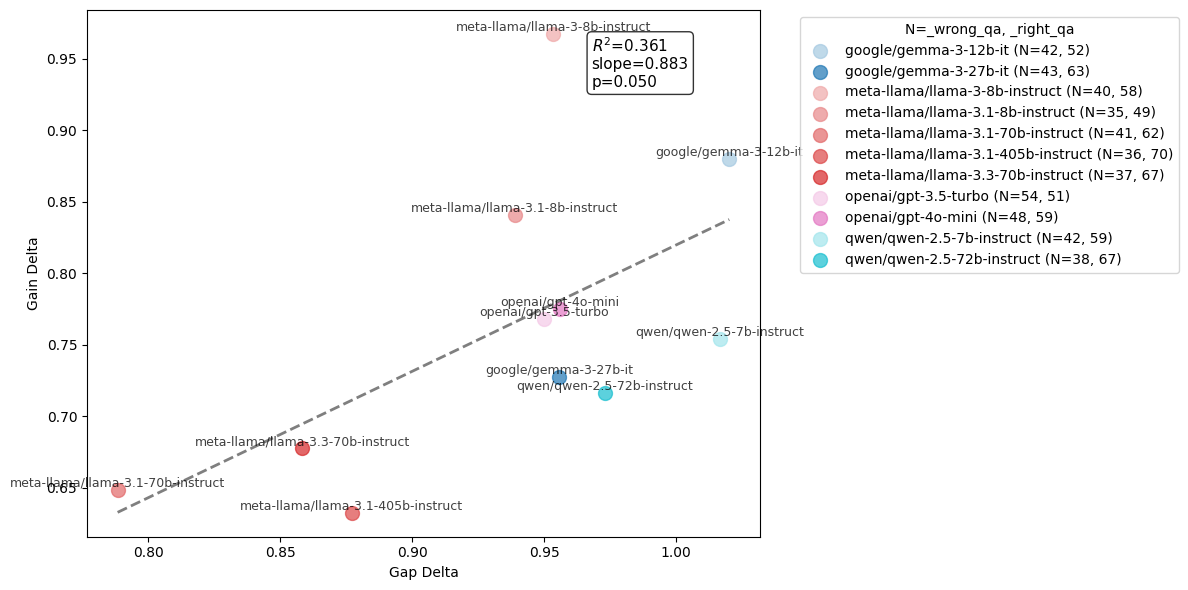

In [22]:
suffixes = ['_wrong_qa', '_right_qa']

merged_domains = wrong_qa_acc.merge(right_qa_acc, on='name', suffixes=suffixes)

temp = merged_domains
temp = merged_domains[(merged_domains['n_total_wrong_qa'] > 30) & (merged_domains['n_total_right_qa'] > 30)]
plot_delta_over_delta(temp, suffixes, xfield='gap_delta', yfield='gain_delta')

### Analyze the juge performance

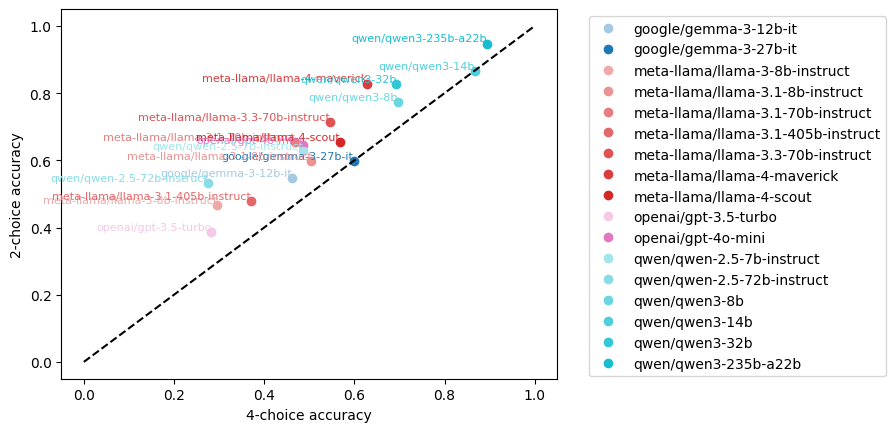

In [23]:
acc_by_model_4_choice = df_4_choice_gpqa.groupby('config_judge_model_verdicts')[['is_correct_verdict']].mean()
acc_by_model_2_choice = df_2_choice_gpqa.groupby('config_judge_model_verdicts')[['is_correct_verdict']].mean()

names, color_map = sort_and_color_by_model_family(acc_by_model_4_choice.index)

acc_by_model_merged = acc_by_model_4_choice.merge(acc_by_model_2_choice, on='config_judge_model_verdicts', suffixes=('_4_choice', '_2_choice'))

for name, x, y in zip(names, acc_by_model_merged['is_correct_verdict_4_choice'], acc_by_model_merged['is_correct_verdict_2_choice']):
    plt.scatter(x, y, c=[color_map[name]], label=name)
    plt.text(x, y, name, fontsize=8, ha='right', va='bottom', color=color_map[name])
handles = [plt.Line2D([0], [0], marker='o', color='w', label=name, markerfacecolor=color_map[name], markersize=8)
           for name in names]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
# set the names of each 
plt.xlabel('4-choice accuracy')
plt.ylabel('2-choice accuracy')
# plot the line y=x
plt.plot([0, 1], [0, 1], 'k--')
plt.show()


In [24]:
acc_by_model_merged['diff'] = acc_by_model_merged['is_correct_verdict_2_choice'] - acc_by_model_merged['is_correct_verdict_4_choice']
acc_by_model_merged.mean(axis=0)

is_correct_verdict_4_choice    0.536566
is_correct_verdict_2_choice    0.655653
diff                           0.119087
dtype: float64

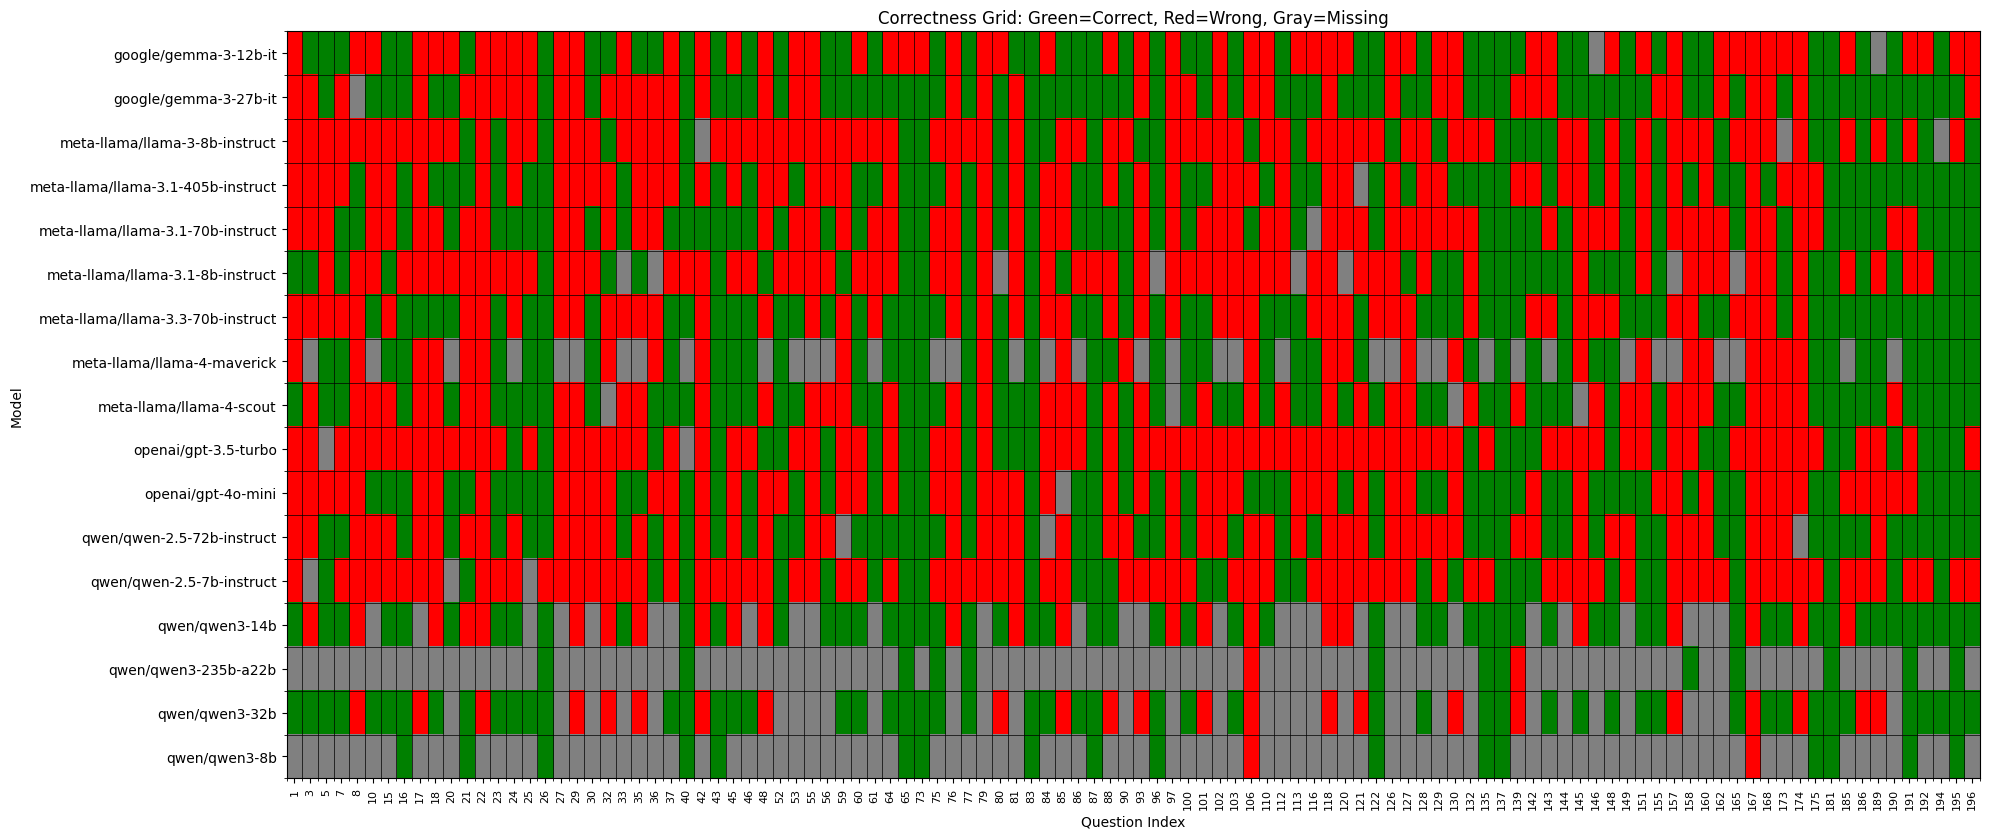

In [ ]:
plot_correctness_grid(df_4_choice_gpqa)

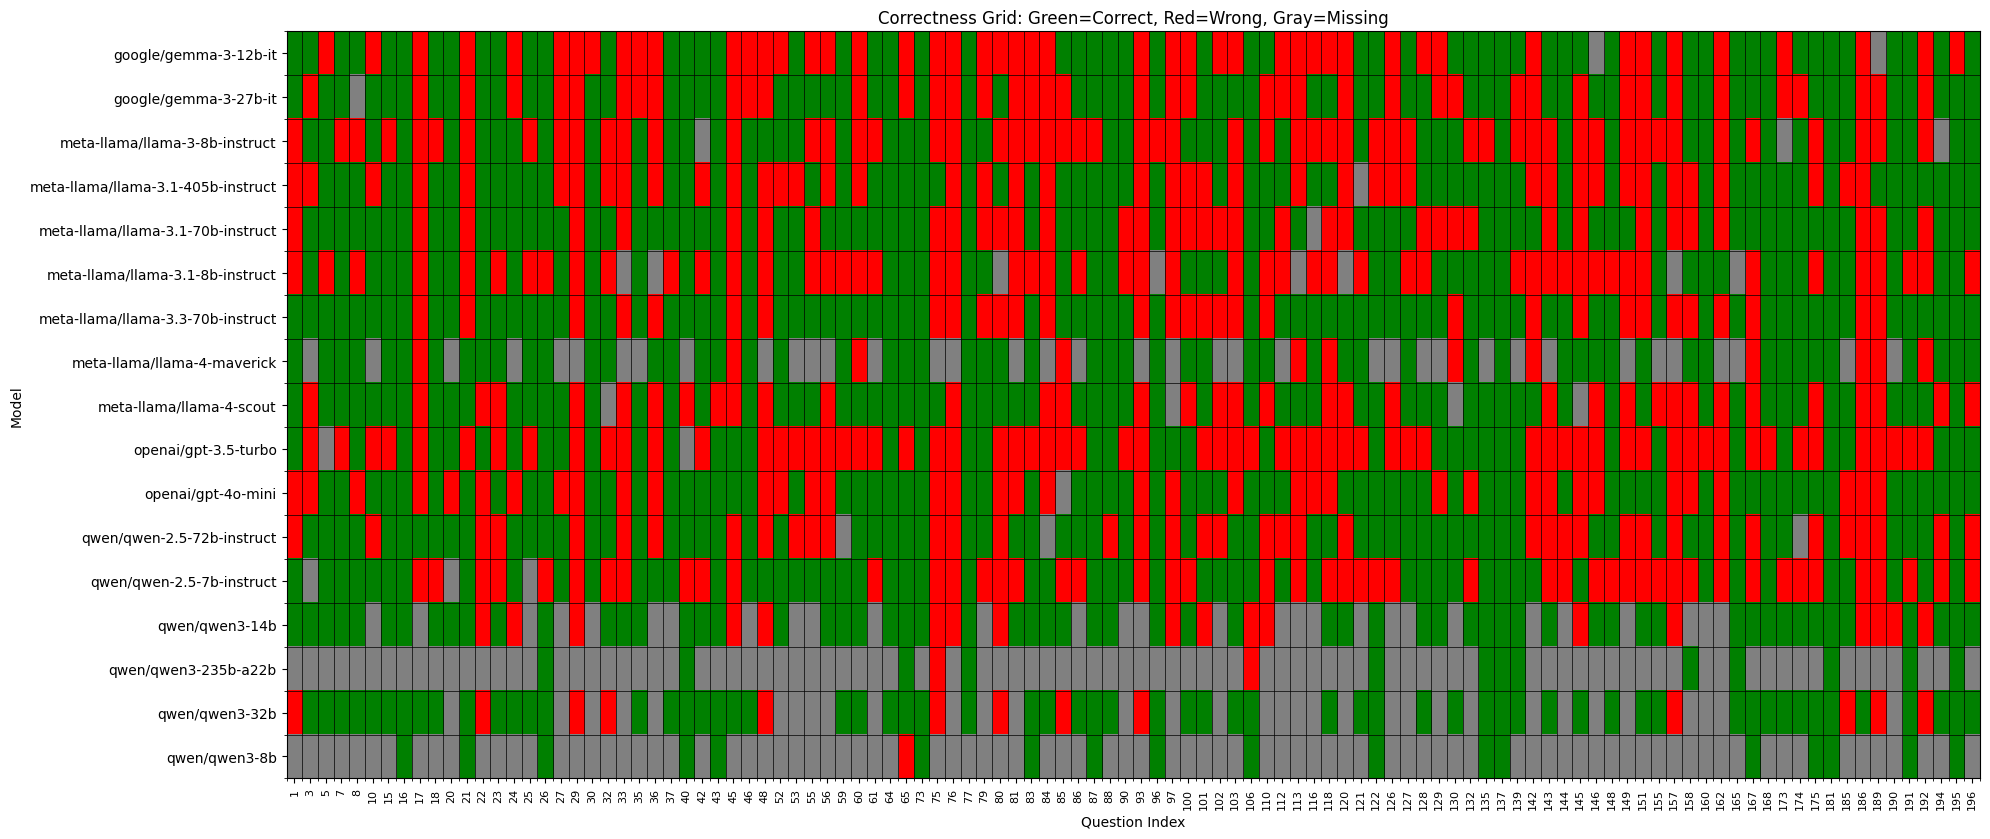

In [26]:
plot_correctness_grid(df_2_choice_gpqa)

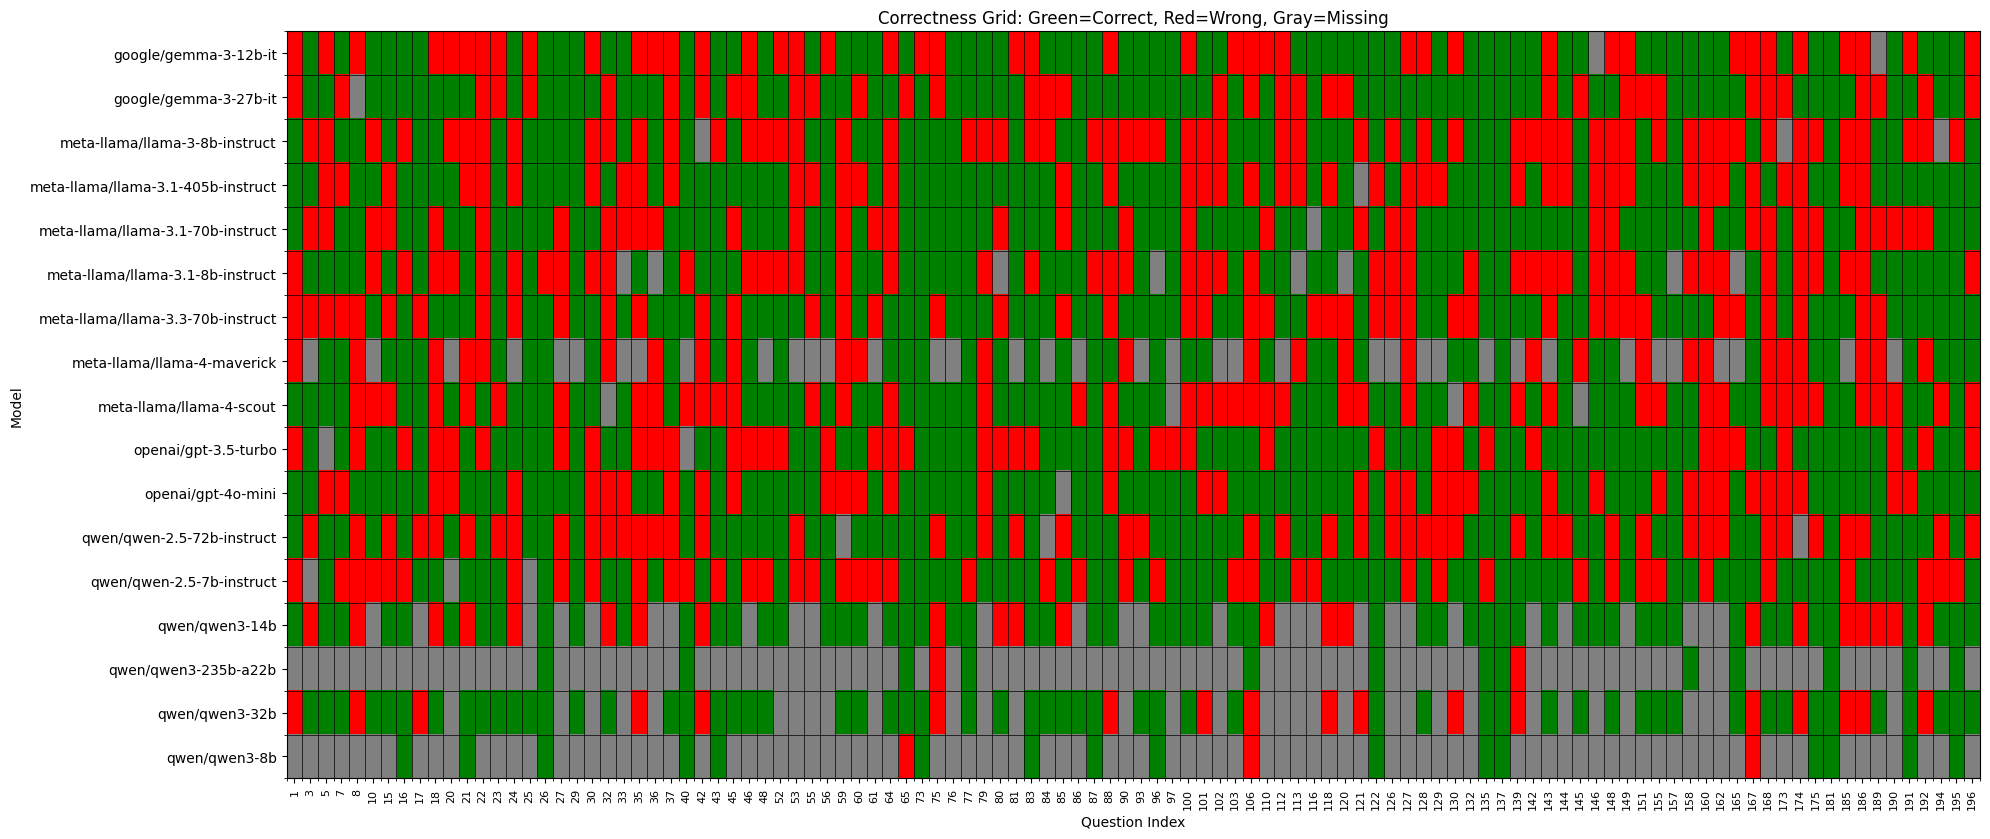

In [27]:
suffixes = ['_2_choice', '_4_choice']
merged_df = df_2_choice_gpqa.merge(df_4_choice_gpqa, on=['question_idx_debates', 'config_judge_model_verdicts'], suffixes=suffixes).reset_index(drop=True)
# merged_df['is_correct_verdict_4_choice'] = np.random.permutation(merged_df['is_correct_verdict_4_choice'].values) # used this to confirm that by chance would be lower agreement
merged_df['is_same_verdict'] = merged_df['is_correct_verdict_2_choice'] == merged_df['is_correct_verdict_4_choice']
plot_correctness_grid(merged_df, value_field='is_same_verdict')

In [28]:
merged_df['is_same_verdict'].value_counts()

is_same_verdict
True     933
False    592
Name: count, dtype: int64

In [29]:
merged_df['is_correct_verdict_2_choice'].value_counts()

is_correct_verdict_2_choice
True     942
False    583
Name: count, dtype: int64

In [30]:
merged_df['is_correct_verdict_4_choice'].value_counts()

is_correct_verdict_4_choice
False    779
True     746
Name: count, dtype: int64

### Count reasoning tokens

<Axes: >

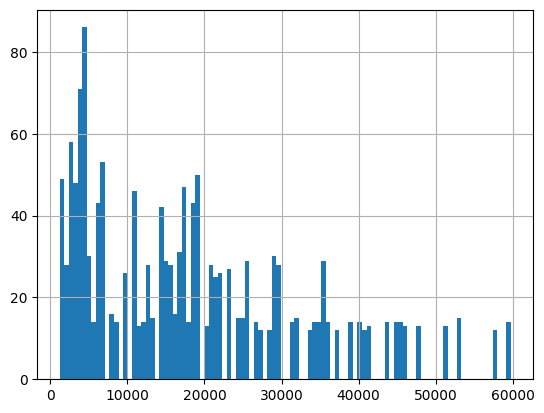

In [31]:
df_4_choice_gpqa['debate_history_debates'].apply(lambda x: sum_reasoning_tokens_over_turns(x)).hist(bins=100)

In [32]:
df_4_choice_gpqa['judge_reasoning_tokens'] = df_4_choice_gpqa['judge_verdict_verdicts'].apply(lambda x: get_reasoning_tokens(x))
df_4_choice_gpqa.groupby('config_judge_model_verdicts')['judge_reasoning_tokens'].sum()

/var/folders/9l/xmd1jn1s1gg47vfyv_n8g3xh0000gn/T/ipykernel_75210/2587502438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_choice_gpqa['judge_reasoning_tokens'] = df_4_choice_gpqa['judge_verdict_verdicts'].apply(lambda x: get_reasoning_tokens(x))


config_judge_model_verdicts
google/gemma-3-12b-it                     0
google/gemma-3-27b-it                     0
meta-llama/llama-3-8b-instruct            0
meta-llama/llama-3.1-405b-instruct        0
meta-llama/llama-3.1-70b-instruct         0
meta-llama/llama-3.1-8b-instruct          0
meta-llama/llama-3.3-70b-instruct         0
meta-llama/llama-4-maverick               0
meta-llama/llama-4-scout                  0
openai/gpt-3.5-turbo                      0
openai/gpt-4o-mini                        0
qwen/qwen-2.5-72b-instruct                0
qwen/qwen-2.5-7b-instruct                 0
qwen/qwen3-14b                            0
qwen/qwen3-235b-a22b                      0
qwen/qwen3-32b                        22268
qwen/qwen3-8b                             0
Name: judge_reasoning_tokens, dtype: int64